In [8]:
pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=a9d736de5c5fcfca8ebcd580f6849e0306d3598ddb61591bfe4c0b0143875cce
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval


In [4]:
import pandas as pd
import numpy as np
from datasets import Dataset
from evaluate import load as load_metric
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification
from peft import get_peft_model, LoraConfig, TaskType
import torch
from typing import List

DATA_FILE_PATH = '/mkpucit_final_ner_input.csv'
df = pd.read_csv(DATA_FILE_PATH)

print(f"Loaded dataset with {len(df)} rows.")

def convert_to_iob(tags: List[str]) -> List[str]:
    iob_tags = []
    previous_tag = 'O'
    for tag in tags:
        # 1. Handle Non-Entity tag
        if tag == 'Other' or tag == 'OTHER':
            iob_tags.append('O')
            previous_tag = 'O'
        # 2. Handle same entity tag (Inside)
        elif tag == previous_tag:
            iob_tags.append(f'I-{tag}')
            previous_tag = tag
        # 3. Handle new entity tag (Beginning)
        else:
            iob_tags.append(f'B-{tag}')
            previous_tag = tag
    return iob_tags

df['Ground_Truth_Tags'] = df['Ground_Truth_Tags'].astype(str).apply(lambda x: x.split())
df['Ground_Truth_Tags'] = df['Ground_Truth_Tags'].apply(convert_to_iob)

NER_TAGS = ['O', 'B-Location', 'I-Location', 'B-Person', 'I-Person', 'B-Organization', 'I-Organization']
id2label = {i: tag for i, tag in enumerate(NER_TAGS)}
label2id = {tag: i for i, tag in enumerate(NER_TAGS)}

print(f"Total IOB Labels: {len(NER_TAGS)}")
print(f"Example IOB tag list (first row): {df['Ground_Truth_Tags'].iloc[0]}")

Loaded dataset with 24276 rows.
Total IOB Labels: 7
Example IOB tag list (first row): ['B-Location', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Person', 'I-Person', 'O', 'O', 'O', 'O', 'B-Location', 'O', 'O', 'O']


In [5]:
MODEL_CHECKPOINT = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)


def tokenize_and_align_labels(example, input_column):

    raw_text = str(example[input_column])
    split_text = raw_text.split()

    tokenized_inputs = tokenizer(
        split_text,  # Pass the list of words, not the full string
        truncation=True,
        is_split_into_words=True,
        max_length=128
    )

    labels = []

    ground_truth = example["Ground_Truth_Tags"]

    word_ids = tokenized_inputs.word_ids() # No batch_index needed for single example
    previous_word_idx = None
    label_ids = []

    # Defensive index check parameters
    max_label_index = len(ground_truth) - 1

    for word_idx in word_ids:
        if word_idx is None:
            # Special tokens like [CLS], [SEP]
            label_ids.append(-100)
        elif word_idx != previous_word_idx:
            # First token of a word: assign the actual IOB label ID
            if word_idx <= max_label_index:
                 label_ids.append(label2id[ground_truth[word_idx]])
            else:
                 # Fallback for mismatches
                 label_ids.append(label2id['O'])
        else:
            # Subsequent subwords: mask with -100
            label_ids.append(-100)
        previous_word_idx = word_idx

    # The trainer expects 'labels' key in the output
    tokenized_inputs["labels"] = label_ids
    return tokenized_inputs

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [6]:

# 1. LoRA CONFIGURATION (PEFT)
lora_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS, # Task is Token Classification (NER)
    inference_mode=False,
    r=16, # Rank: Controls the number of trainable parameters
    lora_alpha=16, # Scaling factor
    lora_dropout=0.1,
    target_modules=["query", "value"], # Target the key attention matrices in XLM-R
)

# 2. TRAINING ARGUMENTS
training_args = TrainingArguments(
    output_dir="./xlmroberta_ner_results",
    learning_rate=2e-4,
    per_device_train_batch_size=32, # Batch size (adjust to 16 if you get OOM errors)
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch", # Fixed deprecated argument
    logging_dir='./logs',
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(), 

In [9]:
#  EVALUATION METRICS
metric = load_metric("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# 2. MAIN TRAINING FUNCTION
def run_ner_fine_tuning(input_column: str, run_name: str, train_dataset, eval_dataset):
    print(f"\n=======================================================")
    print(f"| Starting Fine-Tuning for: {run_name} |")
    print(f"| Input Column: {input_column} |")
    print(f"=======================================================")

    base_model = AutoModelForTokenClassification.from_pretrained(
        MODEL_CHECKPOINT, num_labels=len(NER_TAGS), id2label=id2label, label2id=label2id
    )

    # Apply LoRA to the base model
    lora_model = get_peft_model(base_model, lora_config)
    print(f"LoRA Trainable Params: {lora_model.print_trainable_parameters()}")

    trainer = Trainer(
        model=lora_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        data_collator=DataCollatorForTokenClassification(tokenizer, padding=True),
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # Evaluate the model on the evaluation set
    eval_results = trainer.evaluate()
    print(f"\n--- Final Evaluation Results for {run_name} ---")
    print(eval_results)
    print("---------------------------------------------------\n")
    return eval_results

In [10]:
# --- CELL 5: EXECUTION AND COMPARISON (FILTERED & UNBATCHED) ---

# 1. Convert DataFrame to Hugging Face Dataset format
dataset = Dataset.from_pandas(df)

dataset = dataset.train_test_split(test_size=0.2, seed=42)

def check_word_tag_match(example, input_column):
    """Returns True if the number of words equals the number of tags, False otherwise."""
    # Split the input text into words based on spaces
    input_text = str(example[input_column])
    num_words = len(input_text.split())
    num_tags = len(example['Ground_Truth_Tags'])
    return num_words == num_tags and num_words > 0


# Filter the baseline training and evaluation sets
baseline_train_filtered = dataset['train'].filter(lambda x: check_word_tag_match(x, 'Urdu_Trans_Baseline'))
baseline_eval_filtered = dataset['test'].filter(lambda x: check_word_tag_match(x, 'Urdu_Trans_Baseline'))

print(f"Baseline Train set filtered: {len(baseline_train_filtered)}/{len(dataset['train'])} rows remaining.")

print("Tokenizing and aligning labels for BASELINE data...")
# NOTE: batched=False is crucial here to avoid index errors!
baseline_tokenized_train = baseline_train_filtered.map(
    lambda x: tokenize_and_align_labels(x, 'Urdu_Trans_Baseline'),
    batched=False,
    remove_columns=dataset['train'].column_names
)
baseline_tokenized_eval = baseline_eval_filtered.map(
    lambda x: tokenize_and_align_labels(x, 'Urdu_Trans_Baseline'),
    batched=False,
    remove_columns=dataset['test'].column_names
)

baseline_metrics = run_ner_fine_tuning(
    input_column='Urdu_Trans_Baseline',
    run_name='BASELINE (Noisy Input)',
    train_dataset=baseline_tokenized_train,
    eval_dataset=baseline_tokenized_eval
)


# Filter the optimized training and evaluation sets
optimized_train_filtered = dataset['train'].filter(lambda x: check_word_tag_match(x, 'Urdu_Trans_Optimized'))
optimized_eval_filtered = dataset['test'].filter(lambda x: check_word_tag_match(x, 'Urdu_Trans_Optimized'))

print(f"Optimized Train set filtered: {len(optimized_train_filtered)}/{len(dataset['train'])} rows remaining.")

print("Tokenizing and aligning labels for OPTIMIZED data...")
optimized_tokenized_train = optimized_train_filtered.map(
    lambda x: tokenize_and_align_labels(x, 'Urdu_Trans_Optimized'),
    batched=False,
    remove_columns=dataset['train'].column_names
)
optimized_tokenized_eval = optimized_eval_filtered.map(
    lambda x: tokenize_and_align_labels(x, 'Urdu_Trans_Optimized'),
    batched=False,
    remove_columns=dataset['test'].column_names
)

optimized_metrics = run_ner_fine_tuning(
    input_column='Urdu_Trans_Optimized',
    run_name='OPTIMIZED (Normalized Input)',
    train_dataset=optimized_tokenized_train,
    eval_dataset=optimized_tokenized_eval
)

# --- FINAL COMPARISON ---
print("\n\n#######################################################")
print("#### FINAL F1-SCORE COMPARISON ####")
print(f"BASELINE (Noisy Data) F1: {baseline_metrics['eval_f1']:.4f}")
print(f"OPTIMIZED (Normalized Data) F1: {optimized_metrics['eval_f1']:.4f}")
print("#######################################################")

Filter:   0%|          | 0/19420 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4856 [00:00<?, ? examples/s]

Baseline Train set filtered: 13790/19420 rows remaining.
Tokenizing and aligning labels for BASELINE data...


Map:   0%|          | 0/13790 [00:00<?, ? examples/s]

Map:   0%|          | 0/3446 [00:00<?, ? examples/s]


| Starting Fine-Tuning for: BASELINE (Noisy Input) |
| Input Column: Urdu_Trans_Baseline |


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2082978219.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


trainable params: 595,207 || all params: 278,053,646 || trainable%: 0.2141
LoRA Trainable Params: None


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: k224072 (k224072-national-university-of-computer-and-emerging-sci) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.380900,0.354960,0.307838,0.208525,0.248631,0.901294
2,0.315100,0.278264,0.428467,0.324086,0.369038,0.915050
3,0.265800,0.249655,0.456645,0.457652,0.457148,0.921660
4,0.254300,0.239804,0.476896,0.491089,0.483888,0.924377
5,0.246700,0.236122,0.479476,0.497887,0.488508,0.925136



--- Final Evaluation Results for BASELINE (Noisy Input) ---
{'eval_loss': 0.23612186312675476, 'eval_precision': 0.47947629157820243, 'eval_recall': 0.4978871945618225, 'eval_f1': 0.4885083370887787, 'eval_accuracy': 0.9251363782222698, 'eval_runtime': 7.6576, 'eval_samples_per_second': 450.013, 'eval_steps_per_second': 14.104, 'epoch': 5.0}
---------------------------------------------------



Filter:   0%|          | 0/19420 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4856 [00:00<?, ? examples/s]

Optimized Train set filtered: 14234/19420 rows remaining.
Tokenizing and aligning labels for OPTIMIZED data...


Map:   0%|          | 0/14234 [00:00<?, ? examples/s]

Map:   0%|          | 0/3555 [00:00<?, ? examples/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



| Starting Fine-Tuning for: OPTIMIZED (Normalized Input) |
| Input Column: Urdu_Trans_Optimized |
trainable params: 595,207 || all params: 278,053,646 || trainable%: 0.2141
LoRA Trainable Params: None


/tmp/ipython-input-2082978219.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.154200,0.151182,0.598315,0.783088,0.678344,0.947237
2,0.141500,0.142950,0.614660,0.788340,0.690750,0.950481
3,0.138500,0.136584,0.638114,0.800770,0.710248,0.952557
4,0.135200,0.133296,0.650760,0.794993,0.715682,0.954403
5,0.128700,0.132652,0.649562,0.804447,0.718755,0.954094



--- Final Evaluation Results for OPTIMIZED (Normalized Input) ---
{'eval_loss': 0.13265176117420197, 'eval_precision': 0.6495617755159739, 'eval_recall': 0.8044467787114846, 'eval_f1': 0.7187548881589237, 'eval_accuracy': 0.9540940079654233, 'eval_runtime': 7.7468, 'eval_samples_per_second': 458.901, 'eval_steps_per_second': 14.458, 'epoch': 5.0}
---------------------------------------------------



#######################################################
#### FINAL F1-SCORE COMPARISON ####
BASELINE (Noisy Data) F1: 0.4885
OPTIMIZED (Normalized Data) F1: 0.7188
#######################################################


Re-preparing evaluation dataset...


Filter:   0%|          | 0/4856 [00:00<?, ? examples/s]

Map:   0%|          | 0/3555 [00:00<?, ? examples/s]

Loading LoRA adapters from: ./xlmroberta_ner_results/checkpoint-2225


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-686303367.py:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  viz_trainer = Trainer(


Generating predictions...


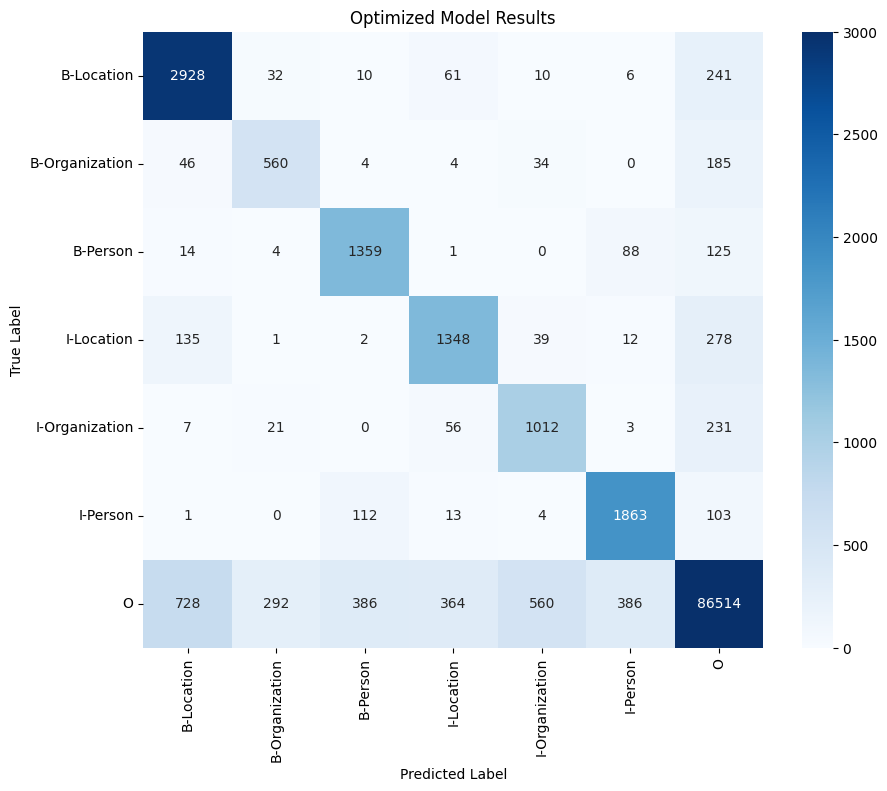


--- Classification Report for Optimized Model Results ---
                precision    recall  f1-score   support

    B-Location       0.76      0.89      0.82      3288
B-Organization       0.62      0.67      0.64       833
      B-Person       0.73      0.85      0.78      1591
    I-Location       0.73      0.74      0.74      1815
I-Organization       0.61      0.76      0.68      1330
      I-Person       0.79      0.89      0.84      2096
             O       0.99      0.97      0.98     89230

      accuracy                           0.95    100183
     macro avg       0.75      0.83      0.78    100183
  weighted avg       0.96      0.95      0.96    100183



In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification, Trainer
from peft import PeftModel
import os

def plot_ner_confusion_matrix(true_labels, pred_labels, title="Confusion Matrix"):
    unique_labels = sorted(list(set(true_labels + pred_labels)))
    cm = confusion_matrix(true_labels, pred_labels, labels=unique_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_labels, yticklabels=unique_labels,
                vmax=3000)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()
    print(f"\n--- Classification Report for {title} ---")
    print(classification_report(true_labels, pred_labels))

def get_predictions_and_labels(trainer, eval_dataset):
    predictions, labels, _ = trainer.predict(eval_dataset)
    predictions = np.argmax(predictions, axis=2)
    true_labels = []
    pred_labels = []
    for i in range(len(labels)):
        for j in range(len(labels[i])):
            if labels[i][j] != -100:
                true_labels.append(id2label[labels[i][j]])
                pred_labels.append(id2label[predictions[i][j]])
    return true_labels, pred_labels

print("Re-preparing evaluation dataset...")
optimized_eval_filtered = dataset['test'].filter(lambda x: check_word_tag_match(x, 'Urdu_Trans_Optimized'))
optimized_tokenized_eval = optimized_eval_filtered.map(
    lambda x: tokenize_and_align_labels(x, 'Urdu_Trans_Optimized'),
    batched=False,
    remove_columns=dataset['test'].column_names
)

# Load the Trained Model (Base + LoRA Adapter)
checkpoints = [d for d in os.listdir("./xlmroberta_ner_results") if "checkpoint" in d]

if checkpoints:
    latest_checkpoint = sorted(checkpoints, key=lambda x: int(x.split('-')[1]))[-1]
    model_path = os.path.join("./xlmroberta_ner_results", latest_checkpoint)
    print(f"Loading LoRA adapters from: {model_path}")

    # A. Load Base Model
    base_model = AutoModelForTokenClassification.from_pretrained(
        MODEL_CHECKPOINT, num_labels=len(NER_TAGS), id2label=id2label, label2id=label2id
    )
    # B. Load Trained LoRA Adapters
    model = PeftModel.from_pretrained(base_model, model_path)

    viz_trainer = Trainer(
        model=model,
        args=training_args,
        eval_dataset=optimized_tokenized_eval, # <--- Fixes the ValueError
        tokenizer=tokenizer,
        data_collator=DataCollatorForTokenClassification(tokenizer, padding=True),
    )

    print("Generating predictions...")
    true_labels, pred_labels = get_predictions_and_labels(viz_trainer, optimized_tokenized_eval)
    plot_ner_confusion_matrix(true_labels, pred_labels, title="Optimized Model Results")

else:
    print("❌ No checkpoints found! You must re-run the training (Cell 5).")

In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from peft import PeftModel

# 1. Configuration
# Ensure these match your training exactly
NER_TAGS = ['O', 'B-Location', 'I-Location', 'B-Person', 'I-Person', 'B-Organization', 'I-Organization']
id2label = {i: tag for i, tag in enumerate(NER_TAGS)}
label2id = {tag: i for i, tag in enumerate(NER_TAGS)}
MODEL_CHECKPOINT = "xlm-roberta-base"
# Update this path to your best checkpoint folder
SAVED_MODEL_PATH = "./xlmroberta_ner_results/checkpoint-2225"

# 2. Load Base Model and Tokenizer
print("Loading XLM-RoBERTa base model...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
base_model = AutoModelForTokenClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=len(NER_TAGS),
    id2label=id2label,
    label2id=label2id
)

# 3. Load Trained LoRA Adapters
print(f"Loading LoRA adapters from {SAVED_MODEL_PATH}...")
model = PeftModel.from_pretrained(base_model, SAVED_MODEL_PATH)
model.eval() # Set to evaluation mode

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("✅ Model loaded successfully!")

Loading XLM-RoBERTa base model...


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading LoRA adapters from ./xlmroberta_ner_results/checkpoint-2225...
✅ Model loaded successfully!


In [13]:
!zip -r model_checkpoint.zip ./xlmroberta_ner_results

  adding: xlmroberta_ner_results/ (stored 0%)
  adding: xlmroberta_ner_results/checkpoint-862/ (stored 0%)
  adding: xlmroberta_ner_results/checkpoint-862/adapter_model.safetensors (deflated 7%)
  adding: xlmroberta_ner_results/checkpoint-862/rng_state.pth (deflated 26%)
  adding: xlmroberta_ner_results/checkpoint-862/optimizer.pt (deflated 7%)
  adding: xlmroberta_ner_results/checkpoint-862/tokenizer.json (deflated 76%)
  adding: xlmroberta_ner_results/checkpoint-862/adapter_config.json (deflated 58%)
  adding: xlmroberta_ner_results/checkpoint-862/sentencepiece.bpe.model (deflated 49%)
  adding: xlmroberta_ner_results/checkpoint-862/special_tokens_map.json (deflated 52%)
  adding: xlmroberta_ner_results/checkpoint-862/scaler.pt (deflated 64%)
  adding: xlmroberta_ner_results/checkpoint-862/tokenizer_config.json (deflated 76%)
  adding: xlmroberta_ner_results/checkpoint-862/training_args.bin (deflated 53%)
  adding: xlmroberta_ner_results/checkpoint-862/trainer_state.json (deflated 67